In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import os
import numpy as np
import torchvision
import torchvision.transforms as transforms

In [2]:
def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()   

In [3]:
#preprocessing and loading the dataset
class SiameseDataset():
    def __init__(self,training_csv=None,training_dir=None,transform=None):
        # used to prepare the labels and images path
        self.train_df=pd.read_csv(training_csv)
        self.train_df.columns =["image1","image2","label"]
        self.train_dir = training_dir    
        self.transform = transform

    def __getitem__(self,index):
        # getting the image path
        image1_path=os.path.join(self.train_dir,self.train_df.iat[index,0])
        image2_path=os.path.join(self.train_dir,self.train_df.iat[index,1])
        # Loading the image
        img0 = Image.open(image1_path)
        img1 = Image.open(image2_path)
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        # Apply image transformations
        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        return img0, img1 , torch.from_numpy(np.array([int(self.train_df.iat[index,2])],dtype=np.float32))
    def __len__(self):
        return len(self.train_df)

In [4]:
# Load the the dataset from raw image folders
training_csv = "train.csv"
training_dir = "data"

siamese_dataset = SiameseDataset(training_csv,training_dir,
                                 transform = transforms.Compose([transforms.Resize((105,105)),
                                                                 transforms.ToTensor()]))

In [5]:
#create a siamese network
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        
        # Setting up the Sequential of CNN Layers
        self.cnn1 = nn.Sequential(
            
            nn.Conv2d(1, 96, kernel_size=11,stride=1),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(5,alpha=0.0001,beta=0.75,k=2),
            nn.MaxPool2d(3, stride=2),
            
            nn.Conv2d(96, 256, kernel_size=5,stride=1,padding=2),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(5,alpha=0.0001,beta=0.75,k=2),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout2d(p=0.3),

            nn.Conv2d(256,384 , kernel_size=3,stride=1,padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(384,256 , kernel_size=3,stride=1,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout2d(p=0.3),

        )
        
        # Defining the fully connected layers
        self.fc1 = nn.Sequential(
            nn.Linear(30976, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.5),
            
            nn.Linear(1024, 128),
            nn.ReLU(inplace=True),
            
            nn.Linear(128,2))
        
  
    def forward_once(self, x):
        # Forward pass 
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        # forward pass of input 1
        output1 = self.forward_once(input1)
        # forward pass of input 2
        output2 = self.forward_once(input2)
        return output1, output2

In [6]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on:
    """

    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, x0, x1, y):
        # euclidian distance
        diff = x0 - x1
        dist_sq = torch.sum(torch.pow(diff, 2), 1)
        dist = torch.sqrt(dist_sq)

        mdist = self.margin - dist
        dist = torch.clamp(mdist, min=0.0)
        loss = y * dist_sq + (1 - y) * torch.pow(dist, 2)
        loss = torch.sum(loss) / 2.0 / x0.size()[0]
        return loss

In [7]:
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=4,
                        batch_size=2)   

Epoch 1
 Current loss -0.4946741461753845

Epoch 2
 Current loss -0.26049619913101196



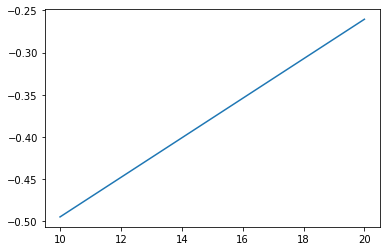

Model Saved Successfully


In [8]:
# Declare Siamese Network
net = SiameseNetwork()
# Decalre Loss Function
criterion = ContrastiveLoss()
# Declare Optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3, weight_decay=0.0005)
#train the model
def train():
    loss=[] 
    counter=[]
    iteration_number = 0
    for epoch in range(1,3): #config.epochs):
        for i, data in enumerate(train_dataloader,0):
            img0, img1 , label = data
            img0, img1 , label = img0, img1, label
            optimizer.zero_grad()
            output1,output2 = net(img0,img1)
            loss_contrastive = criterion(output1,output2,label)
            loss_contrastive.backward()
            optimizer.step()    
        print("Epoch {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
        iteration_number += 10
        counter.append(iteration_number)
        loss.append(loss_contrastive.item())
    show_plot(counter, loss)   
    return net
#set the device to cuda
device = torch.device('cpu')
model = train()
torch.save(model.state_dict(), "model.pt")
print("Model Saved Successfully")

In [9]:
testing_csv = "test.csv"
testing_dir = "data"

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 4 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


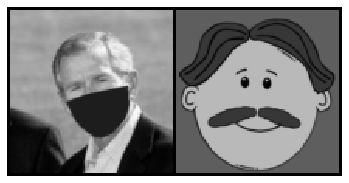

Predicted Eucledian Distance:- 0.08957207947969437
Actual Label:- Same


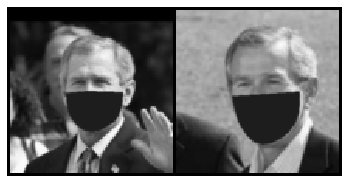

Predicted Eucledian Distance:- 0.04895429685711861
Actual Label:- Same


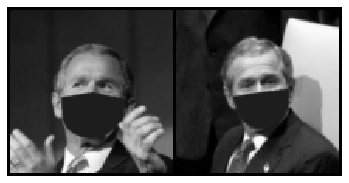

Predicted Eucledian Distance:- 0.05378308519721031
Actual Label:- Same


In [10]:
# Load the test dataset
test_dataset = SiameseDataset(training_csv=testing_csv,training_dir=testing_dir,
                                transform=transforms.Compose([transforms.Resize((105,105)), transforms.ToTensor()]))

test_dataloader = DataLoader(test_dataset,num_workers=6,batch_size=1,shuffle=True)
#test the network
count=0

for i, data in enumerate(test_dataloader,0): 
    x0, x1 , label = data
    concat = torch.cat((x0,x1),0)
    output1,output2 = model(x0.to(device),x1.to(device))

    eucledian_distance = F.pairwise_distance(output1, output2)

    #if label==torch.FloatTensor([[0]]):
    #    label="Original Pair Of Signature"
    #else:
    #    label="Forged Pair Of Signature"
    
    if (abs(eucledian_distance.item()) < 0.5):
        label = "Same"
    else:
        label = "Different"

    imshow(torchvision.utils.make_grid(concat))
    print("Predicted Eucledian Distance:-",eucledian_distance.item())
    print("Actual Label:-",label)
    count=count+1
    if count == 10:
        break